In [3]:
using DelimitedFiles
using NonNegLeastSquares
using LinearAlgebra

In [46]:
using Plots
theme(:vibrant)
gr(frame=:box, linewidth=2.0)

Plots.GRBackend()

In [4]:
function assemble_matrix(N, D, dz)
    A = zeros(N, N)
    for i in 1:N        
        A[i, i] = -(D[i] + D[i + 1]) / dz^2

        if i > 1
            A[i, i - 1] = D[i] / dz^2
        else
            # zero b.c. at z=0
            A[i, i] -= D[i] / dz^2
        end

        if i < N
            A[i, i + 1] = D[i + 1] / dz^2
        else
            # zero b.c. at z=L
            A[i, i] -= D[i + 1] / dz^2
        end
    end

    return A
end

assemble_matrix (generic function with 1 method)

In [5]:
function loaddata(id::String)
    data = "data"
    tobs, yobs = eachcol(readdlm(joinpath(data, "MMIA_$(id)_1.txt"), ','))
    tfit, yfit = eachcol(readdlm(joinpath(data, "fitting_soler_$(id)_1.txt"), ','))

    return (tobs, yobs, yfit)
end

loaddata(id::Integer) = loaddata(string(id))


loaddata (generic function with 2 methods)

In [7]:
tobs, yobs, yfit = loaddata(3544)

tobs .-= 1.5e-4
yobs = yobs[tobs .>= 0]
tobs = tobs[tobs .>= 0]


In [32]:
# Total extension (m)
L = 10e3

# number of cells
N = 64

# cell and center faces
zf = range(0, L, length=N + 1)    
dz = zf[2] - zf[1]
zc = zf[1: end - 1] .+ dz / 2

78.125:156.25:9921.875

In [33]:
# diffusion at cell boundaries (lin. decrease from 12e9 to 3e9 m^2/s)
D = @. 12e9 - (12e9 - 3e9) * zf / L;

In [34]:
# A is the linear diffusion matrix, i.e. the photon density u evolves as
# (∂/∂t) u = A u
A = assemble_matrix(N, D, dz)

64×64 Matrix{Float64}:
     -1.4688e6   485760.0        0.0  …        0.0        0.0        0.0
 485760.0       -965760.0   480000.0           0.0        0.0        0.0
      0.0        480000.0  -954240.0           0.0        0.0        0.0
      0.0             0.0   474240.0           0.0        0.0        0.0
      0.0             0.0        0.0           0.0        0.0        0.0
      0.0             0.0        0.0  …        0.0        0.0        0.0
      0.0             0.0        0.0           0.0        0.0        0.0
      0.0             0.0        0.0           0.0        0.0        0.0
      0.0             0.0        0.0           0.0        0.0        0.0
      0.0             0.0        0.0           0.0        0.0        0.0
      ⋮                               ⋱                        
      0.0             0.0        0.0  …        0.0        0.0        0.0
      0.0             0.0        0.0           0.0        0.0        0.0
      0.0             0.0        0.0 

In [35]:
# The photon density at time t is then exp(At) * u0.
# Note: this is not the element-wise exponential but the matrix exponential
# exp(At) ≈ 1 + At + (1/2) A^2 t^2 + ...
#
# Since we are interested only in the flux at the 0 boundary, this is
# (∂/∂z) D u(z=0) ≈ 2 * D[1] * u[1] / dz
# and u[1] = exp(t * A)[1, :] * u0
#
F = vcat(map(t -> (2 * D[1] / dz) .* exp(t * A)[1, :]', tobs)...)

786×64 Matrix{Float64}:
      1.536e8     1.9366e-6   9.0329e-9  …   2.80764e-8   -2.49015e-9
      1.03632e6   2.80378e6   3.76076e6      5.98563e-10  -4.61158e-11
 358533.0         1.02798e6   1.54857e6      7.10281e-11   9.78071e-11
 193846.0         5.66006e5   8.84561e5      3.19532e-11   3.40982e-11
      1.25494e5   3.69707e5   5.8829e5       1.86505e-10   6.47696e-11
  89622.8         2.65431e5   4.26907e5  …  -7.45394e-11  -2.17107e-11
  68092.3         2.02373e5   3.27803e5      1.2184e-11    9.40368e-12
  53987.6         1.60853e5   2.61867e5     -3.62828e-11  -1.04305e-11
  44159.5         1.31816e5   2.15405e5      7.24511e-11  -6.6169e-12
  36989.8         1.10574e5   1.81222e5      5.07941e-9    9.44239e-10
      ⋮                                  ⋱                
      7.30753    22.086      37.0115        60.3099       20.7584
      7.2596     21.9411     36.7687        59.9143       20.6222
      7.21198    21.7972     36.5276        59.5213       20.4869
      7.164

In [36]:
# F is now a matrix that given an initial photon density u0
# produces the flux at z=0 at different times as F * u0.
# We may use it now to infer the initial source density
# from the measurement.

# Ordinary least squares does noy yield physical results because it fits
# too much of the noise and infers negative source intensity.
# psi0 = F \ yobs

# Constraining the source values to be positive we obtain more sensible
# results.
u0 = nonneg_lsq(F, yobs; alg=:nnls);

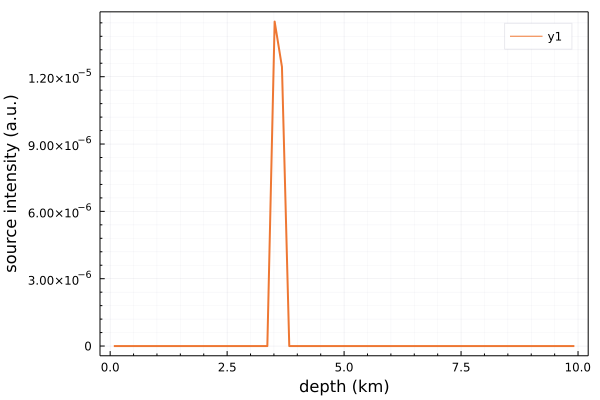

In [47]:

plot(zc / 1e3, u0, xlabel="depth (km)", ylabel="source intensity (a.u.)")

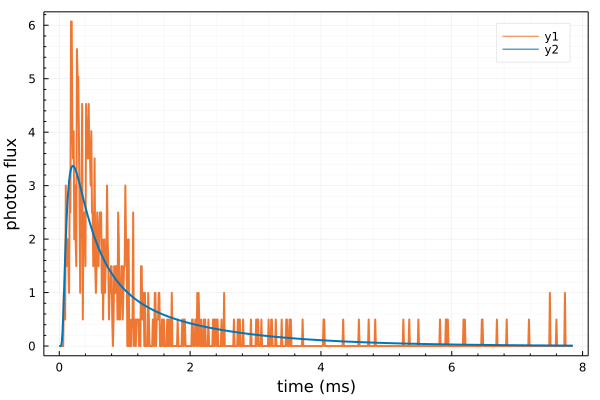

In [49]:
plot(tobs * 1e3, yobs, xlabel="time (ms)", ylabel="photon flux")
plot!(tobs * 1e3, F * u0, xlabel="time (ms)", ylabel="photon flux")
